In [1]:
import os
import functools
import operator
import concurrent.futures

In [2]:
import h5py
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import lib

In [4]:
lib.plotting.setup()

In [5]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

assert shear_step_plus in lib.const.SHEAR_STEPS
assert shear_step_minus in lib.const.SHEAR_STEPS

In [6]:
with h5py.File(lib.const.Y6_REDSHIFT_CATALOG, "r") as shear_y6:
    zbinsc = shear_y6["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]
    
    nz_y6 = {}
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        _nz = shear_y6["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
        # nz_y6[tomographic_bin] = _nz / np.sum(_nz) * _DZ
        _nz = np.append([0], _nz)
        nz_y6[tomographic_bin] = _nz / np.sum(_nz)


In [7]:
with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_plus]) as tomo_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_plus]) as weight_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_minus]) as tomo_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
    h5py.File(lib.const.SIM_WEIGHT_CATALOGS[shear_step_minus]) as weight_minus,
):
    bhat_plus = tomo_plus["sompz"]["noshear"]["bhat"][:]
    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    statistical_weight_plus = weight_plus["mdet"]["noshear"]["statistical_weight"][:]
    nz_match_plus = weight_plus["mdet"]["noshear"]["nz_weight"][:]
    w_match_plus = weight_plus["mdet"]["noshear"]["occupancy_weight"][:]
    nbr_match_plus = weight_plus["mdet"]["noshear"]["neighbor_weight"][:]
    response_plus = lib.response.get_shear_response(shear_plus["mdet"]["noshear"])

    bhat_minus = tomo_minus["sompz"]["noshear"]["bhat"][:]
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    statistical_weight_minus = weight_minus["mdet"]["noshear"]["statistical_weight"][:]
    nz_match_minus = weight_minus["mdet"]["noshear"]["nz_weight"][:]
    w_match_minus = weight_minus["mdet"]["noshear"]["occupancy_weight"][:]
    nbr_match_minus = weight_minus["mdet"]["noshear"]["neighbor_weight"][:]
    response_minus = lib.response.get_shear_response(shear_minus["mdet"]["noshear"])

In [8]:
_zedges = np.copy(lib.const.ZEDGES)
_zedges[-1] = 4

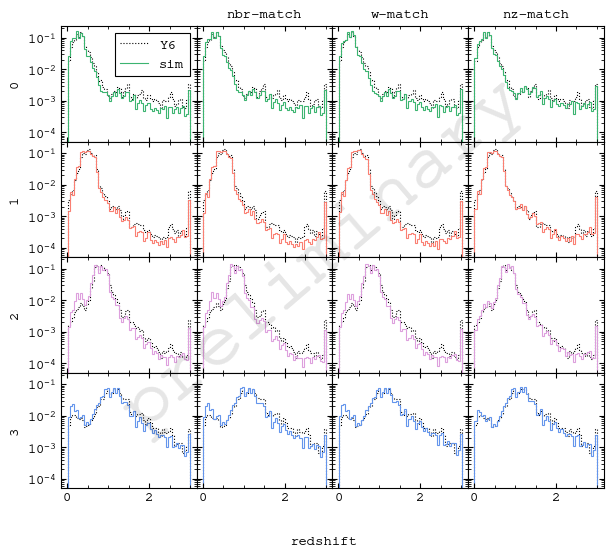

In [9]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(4, 4, figsize=(7, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    in_tomo_plus = (bhat_plus == tomographic_bin)

    nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus)[in_tomo_plus], bins=_zedges)
    nz_nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nz_match_plus)[in_tomo_plus], bins=_zedges)
    nz_w_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * w_match_plus)[in_tomo_plus], bins=_zedges)
    nz_nbr_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nbr_match_plus)[in_tomo_plus], bins=_zedges)

    in_tomo_minus = (bhat_minus == tomographic_bin)

    nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus)[in_tomo_minus], bins=_zedges)
    nz_nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nz_match_minus)[in_tomo_minus], bins=_zedges)
    nz_w_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * w_match_minus)[in_tomo_minus], bins=_zedges)
    nz_nbr_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nbr_match_minus)[in_tomo_minus], bins=_zedges)

    
    nz_plus[1] += nz_plus[0]
    nz_plus[0] = 0

    nz_nz_plus[1] += nz_nz_plus[0]
    nz_nz_plus[0] = 0

    nz_w_plus[1] += nz_w_plus[0]
    nz_w_plus[0] = 0

    nz_nbr_plus[1] += nz_nbr_plus[0]
    nz_nbr_plus[0] = 0

    nz_plus = nz_plus / np.sum(nz_plus)
    nz_nz_plus = nz_nz_plus / np.sum(nz_nz_plus)
    nz_w_plus = nz_w_plus / np.sum(nz_w_plus)
    nz_nbr_plus = nz_nbr_plus / np.sum(nz_nbr_plus)
    
    nz_minus[1] += nz_minus[0]
    nz_minus[0] = 0

    nz_nz_minus[1] += nz_nz_minus[0]
    nz_nz_minus[0] = 0

    nz_w_minus[1] += nz_w_minus[0]
    nz_w_minus[0] = 0

    nz_nbr_minus[1] += nz_nbr_minus[0]
    nz_nbr_minus[0] = 0

    nz_minus = nz_minus / np.sum(nz_minus)
    nz_nz_minus = nz_nz_minus / np.sum(nz_nz_minus)
    nz_w_minus = nz_w_minus / np.sum(nz_w_minus)
    nz_nbr_minus = nz_nbr_minus / np.sum(nz_nbr_minus)

    nz = (nz_plus + nz_minus) / 2.
    nz_nz = (nz_nz_plus + nz_nz_minus) / 2.
    nz_w = (nz_w_plus + nz_w_minus) / 2.
    nz_nbr = (nz_nbr_plus + nz_nbr_minus) / 2.
    
    # axs[tomographic_bin].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k")
    # axs[tomographic_bin].stairs(nz, lib.const.ZEDGES, label="sim", ec="k", ls=":")
    # axs[tomographic_bin].stairs(nz_w, lib.const.ZEDGES, label="sim [nz-match]", ec="cornflowerblue")

    axs[tomographic_bin, 0].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k", ls=":")
    axs[tomographic_bin, 0].stairs(nz, lib.const.ZEDGES, label="sim", ec=tomo_colors[tomographic_bin])

    axs[tomographic_bin, 1].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k", ls=":")
    axs[tomographic_bin, 1].stairs(nz_nbr, lib.const.ZEDGES, label="sim [nbr-match]", ec=tomo_colors[tomographic_bin])

    axs[tomographic_bin, 2].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k", ls=":")
    axs[tomographic_bin, 2].stairs(nz_w, lib.const.ZEDGES, label="sim [w-match]", ec=tomo_colors[tomographic_bin])

    axs[tomographic_bin, 3].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k", ls=":")
    axs[tomographic_bin, 3].stairs(nz_nz, lib.const.ZEDGES, label="sim [nz-match]", ec=tomo_colors[tomographic_bin])

    
axs[0, 0].set_ylabel("0")
axs[1, 0].set_ylabel("1")
axs[2, 0].set_ylabel("2")
axs[3, 0].set_ylabel("3")

axs[0, 1].set_title("nbr-match")
axs[0, 2].set_title("w-match")
axs[0, 3].set_title("nz-match")

axs[0, 0].legend(loc="upper right")
axs[0, 0].set_yscale("log")
# axs[0].set_ylim(1e-3, 1e2)

fig.supxlabel("redshift")

lib.plotting.watermark(fig)

# plt.savefig("weights.pdf")

plt.show()

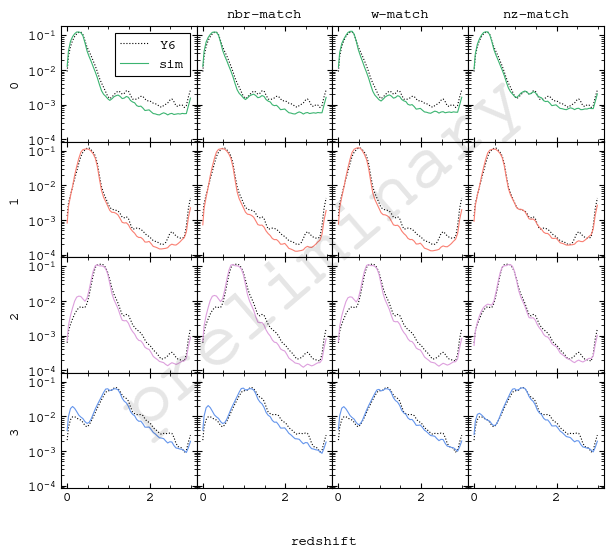

In [10]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(4, 4, figsize=(7, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    in_tomo_plus = (bhat_plus == tomographic_bin)

    nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus)[in_tomo_plus], bins=_zedges)
    nz_nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nz_match_plus)[in_tomo_plus], bins=_zedges)
    nz_w_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * w_match_plus)[in_tomo_plus], bins=_zedges)
    nz_nbr_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nbr_match_plus)[in_tomo_plus], bins=_zedges)

    in_tomo_minus = (bhat_minus == tomographic_bin)

    nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus)[in_tomo_minus], bins=_zedges)
    nz_nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nz_match_minus)[in_tomo_minus], bins=_zedges)
    nz_w_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * w_match_minus)[in_tomo_minus], bins=_zedges)
    nz_nbr_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nbr_match_minus)[in_tomo_minus], bins=_zedges)

    
    nz_plus[1] += nz_plus[0]
    nz_plus[0] = 0

    nz_nz_plus[1] += nz_nz_plus[0]
    nz_nz_plus[0] = 0

    nz_w_plus[1] += nz_w_plus[0]
    nz_w_plus[0] = 0

    nz_nbr_plus[1] += nz_nbr_plus[0]
    nz_nbr_plus[0] = 0

    nz_plus = nz_plus / np.sum(nz_plus)
    nz_nz_plus = nz_nz_plus / np.sum(nz_nz_plus)
    nz_w_plus = nz_w_plus / np.sum(nz_w_plus)
    nz_nbr_plus = nz_nbr_plus / np.sum(nz_nbr_plus)
    
    nz_minus[1] += nz_minus[0]
    nz_minus[0] = 0

    nz_nz_minus[1] += nz_nz_minus[0]
    nz_nz_minus[0] = 0

    nz_w_minus[1] += nz_w_minus[0]
    nz_w_minus[0] = 0

    nz_nbr_minus[1] += nz_nbr_minus[0]
    nz_nbr_minus[0] = 0

    nz_minus = nz_minus / np.sum(nz_minus)
    nz_nz_minus = nz_nz_minus / np.sum(nz_nz_minus)
    nz_w_minus = nz_w_minus / np.sum(nz_w_minus)
    nz_nbr_minus = nz_nbr_minus / np.sum(nz_nbr_minus)

    nz = (nz_plus + nz_minus) / 2.
    nz_nz = (nz_nz_plus + nz_nz_minus) / 2.
    nz_w = (nz_w_plus + nz_w_minus) / 2.
    nz_nbr = (nz_nbr_plus + nz_nbr_minus) / 2.
    
    # axs[tomographic_bin].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k")
    # axs[tomographic_bin].stairs(nz, lib.const.ZEDGES, label="sim", ec="k", ls=":")
    # axs[tomographic_bin].stairs(nz_w, lib.const.ZEDGES, label="sim [nz-match]", ec="cornflowerblue")

    lib.plotting.contour1d(
        axs[tomographic_bin, 0],
        nz_y6[tomographic_bin],
        lib.const.ZEDGES,
        label="Y6",
        c="k",
        ls=":",
    )
    lib.plotting.contour1d(
        axs[tomographic_bin, 0],
        nz,
        lib.const.ZEDGES,
        label="sim",
        c=tomo_colors[tomographic_bin],
    )

    lib.plotting.contour1d(
        axs[tomographic_bin, 1],
        nz_y6[tomographic_bin],
        lib.const.ZEDGES,
        label="Y6",
        c="k",
        ls=":",
    )
    lib.plotting.contour1d(
        axs[tomographic_bin, 1],
        nz_nbr,
        lib.const.ZEDGES,
        label="sim [nbr-match]",
        c=tomo_colors[tomographic_bin],
    )

    lib.plotting.contour1d(
        axs[tomographic_bin, 2],
        nz_y6[tomographic_bin],
        lib.const.ZEDGES,
        label="Y6",
        c="k",
        ls=":",
    )
    lib.plotting.contour1d(
        axs[tomographic_bin, 2],
        nz_w,
        lib.const.ZEDGES,
        label="sim [w-match]",
        c=tomo_colors[tomographic_bin],
    )

    lib.plotting.contour1d(
        axs[tomographic_bin, 3],
        nz_y6[tomographic_bin],
        lib.const.ZEDGES,
        label="Y6",
        c="k",
        ls=":",
    )
    lib.plotting.contour1d(
        axs[tomographic_bin, 3],
        nz_nz,
        lib.const.ZEDGES,
        label="sim [nz-match]",
        c=tomo_colors[tomographic_bin],
    )
    
axs[0, 0].set_ylabel("0")
axs[1, 0].set_ylabel("1")
axs[2, 0].set_ylabel("2")
axs[3, 0].set_ylabel("3")

axs[0, 1].set_title("nbr-match")
axs[0, 2].set_title("w-match")
axs[0, 3].set_title("nz-match")

axs[0, 0].legend(loc="upper right")
axs[0, 0].set_yscale("log")
# axs[0].set_ylim(1e-3, 1e2)

fig.supxlabel("redshift")

lib.plotting.watermark(fig)

# plt.savefig("weights.pdf")

plt.show()

/tmp/ipykernel_1642767/2020835999.py:65: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="sim", ec="k")
/tmp/ipykernel_1642767/2020835999.py:66: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_nbr / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nbr-match", ec="darkseagreen")
/tmp/ipykernel_1642767/2020835999.py:67: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_w / nz_y6[tomographic_bin], lib.const.ZEDGES, label="w-match", ec="cornflowerblue")
/tmp/ipykernel_1642767/2020835999.py:68: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nz-match", ec="lightcoral")


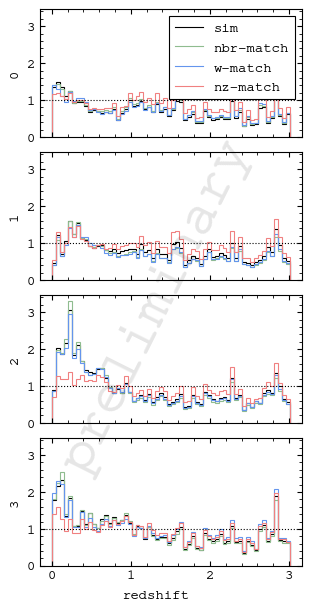

In [11]:
# fig, axs = plt.subplots(4, 1, figsize=(3, 6), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0, hspace=0)

fig, axs = plt.subplots(4, 1, figsize=(3, 6), sharex=True, sharey=True, constrained_layout=True)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    in_tomo_plus = (bhat_plus == tomographic_bin)

    nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus)[in_tomo_plus], bins=_zedges)
    nz_nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nz_match_plus)[in_tomo_plus], bins=_zedges)
    nz_w_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * w_match_plus)[in_tomo_plus], bins=_zedges)
    nz_nbr_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nbr_match_plus)[in_tomo_plus], bins=_zedges)

    in_tomo_minus = (bhat_minus == tomographic_bin)

    nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus)[in_tomo_minus], bins=_zedges)
    nz_nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nz_match_minus)[in_tomo_minus], bins=_zedges)
    nz_w_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * w_match_minus)[in_tomo_minus], bins=_zedges)
    nz_nbr_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nbr_match_minus)[in_tomo_minus], bins=_zedges)

    
    nz_plus[1] += nz_plus[0]
    nz_plus[0] = 0

    nz_nz_plus[1] += nz_nz_plus[0]
    nz_nz_plus[0] = 0

    nz_w_plus[1] += nz_w_plus[0]
    nz_w_plus[0] = 0

    nz_nbr_plus[1] += nz_nbr_plus[0]
    nz_nbr_plus[0] = 0

    nz_plus = nz_plus / np.sum(nz_plus)
    nz_nz_plus = nz_nz_plus / np.sum(nz_nz_plus)
    nz_w_plus = nz_w_plus / np.sum(nz_w_plus)
    nz_nbr_plus = nz_nbr_plus / np.sum(nz_nbr_plus)
    
    nz_minus[1] += nz_minus[0]
    nz_minus[0] = 0

    nz_nz_minus[1] += nz_nz_minus[0]
    nz_nz_minus[0] = 0

    nz_w_minus[1] += nz_w_minus[0]
    nz_w_minus[0] = 0

    nz_nbr_minus[1] += nz_nbr_minus[0]
    nz_nbr_minus[0] = 0

    nz_minus = nz_minus / np.sum(nz_minus)
    nz_nz_minus = nz_nz_minus / np.sum(nz_nz_minus)
    nz_w_minus = nz_w_minus / np.sum(nz_w_minus)
    nz_nbr_minus = nz_nbr_minus / np.sum(nz_nbr_minus)

    nz = (nz_plus + nz_minus) / 2.
    nz_nz = (nz_nz_plus + nz_nz_minus) / 2.
    nz_w = (nz_w_plus + nz_w_minus) / 2.
    nz_nbr = (nz_nbr_plus + nz_nbr_minus) / 2.

    # axs[tomographic_bin].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k")
    # axs[tomographic_bin].stairs(nz, lib.const.ZEDGES, label="sim", ec="k", ls=":")
    # axs[tomographic_bin].stairs(nz_w, lib.const.ZEDGES, label="sim [nz-match]", ec="cornflowerblue")
    axs[tomographic_bin].axhline(1, c="k", ls=":")
    axs[tomographic_bin].stairs(nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="sim", ec="k")
    axs[tomographic_bin].stairs(nz_nbr / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nbr-match", ec="darkseagreen")
    axs[tomographic_bin].stairs(nz_w / nz_y6[tomographic_bin], lib.const.ZEDGES, label="w-match", ec="cornflowerblue")
    axs[tomographic_bin].stairs(nz_nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nz-match", ec="lightcoral")

    axs[tomographic_bin].set_ylabel(tomographic_bin)


axs[0].legend(loc="upper right")
# axs[0].set_yscale("log")
# axs[0].set_ylim(1e-3, 1e2)

fig.supxlabel("redshift")

lib.plotting.watermark(fig)

# plt.savefig("weights.pdf")


plt.show()

/tmp/ipykernel_1642767/1663785372.py:67: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="sim", ec="k")
/tmp/ipykernel_1642767/1663785372.py:68: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_nbr / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nbr-match", ec="darkseagreen")
/tmp/ipykernel_1642767/1663785372.py:69: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_w / nz_y6[tomographic_bin], lib.const.ZEDGES, label="w-match", ec="cornflowerblue")
/tmp/ipykernel_1642767/1663785372.py:70: RuntimeWarning: invalid value encountered in divide
  axs[tomographic_bin].stairs(nz_nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nz-match", ec="lightcoral")


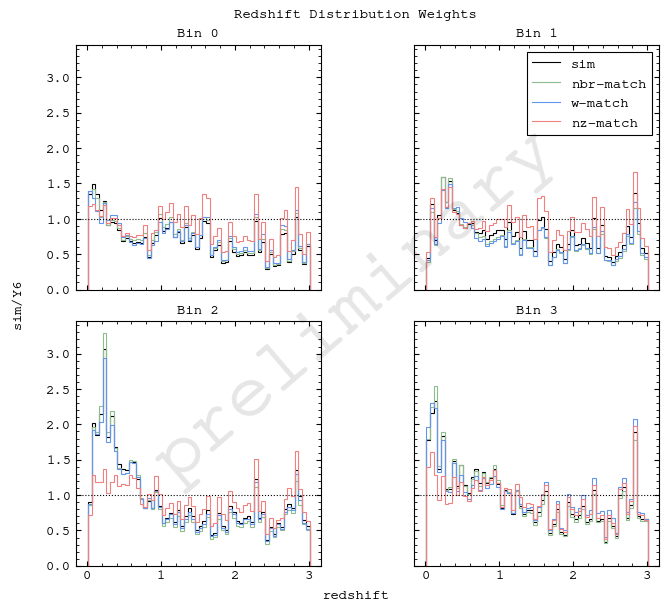

In [18]:
# fig, axs = plt.subplots(4, 1, figsize=(3, 6), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0, hspace=0)

fig, axs = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True, constrained_layout=True)

axs = axs.ravel()

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    in_tomo_plus = (bhat_plus == tomographic_bin)

    nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus)[in_tomo_plus], bins=_zedges)
    nz_nz_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nz_match_plus)[in_tomo_plus], bins=_zedges)
    nz_w_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * w_match_plus)[in_tomo_plus], bins=_zedges)
    nz_nbr_plus, _ = np.histogram(redshift_plus[in_tomo_plus], weights=(response_plus * statistical_weight_plus * nbr_match_plus)[in_tomo_plus], bins=_zedges)

    in_tomo_minus = (bhat_minus == tomographic_bin)

    nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus)[in_tomo_minus], bins=_zedges)
    nz_nz_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nz_match_minus)[in_tomo_minus], bins=_zedges)
    nz_w_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * w_match_minus)[in_tomo_minus], bins=_zedges)
    nz_nbr_minus, _ = np.histogram(redshift_minus[in_tomo_minus], weights=(response_minus * statistical_weight_minus * nbr_match_minus)[in_tomo_minus], bins=_zedges)

    
    nz_plus[1] += nz_plus[0]
    nz_plus[0] = 0

    nz_nz_plus[1] += nz_nz_plus[0]
    nz_nz_plus[0] = 0

    nz_w_plus[1] += nz_w_plus[0]
    nz_w_plus[0] = 0

    nz_nbr_plus[1] += nz_nbr_plus[0]
    nz_nbr_plus[0] = 0

    nz_plus = nz_plus / np.sum(nz_plus)
    nz_nz_plus = nz_nz_plus / np.sum(nz_nz_plus)
    nz_w_plus = nz_w_plus / np.sum(nz_w_plus)
    nz_nbr_plus = nz_nbr_plus / np.sum(nz_nbr_plus)
    
    nz_minus[1] += nz_minus[0]
    nz_minus[0] = 0

    nz_nz_minus[1] += nz_nz_minus[0]
    nz_nz_minus[0] = 0

    nz_w_minus[1] += nz_w_minus[0]
    nz_w_minus[0] = 0

    nz_nbr_minus[1] += nz_nbr_minus[0]
    nz_nbr_minus[0] = 0

    nz_minus = nz_minus / np.sum(nz_minus)
    nz_nz_minus = nz_nz_minus / np.sum(nz_nz_minus)
    nz_w_minus = nz_w_minus / np.sum(nz_w_minus)
    nz_nbr_minus = nz_nbr_minus / np.sum(nz_nbr_minus)

    nz = (nz_plus + nz_minus) / 2.
    nz_nz = (nz_nz_plus + nz_nz_minus) / 2.
    nz_w = (nz_w_plus + nz_w_minus) / 2.
    nz_nbr = (nz_nbr_plus + nz_nbr_minus) / 2.

    # axs[tomographic_bin].stairs(nz_y6[tomographic_bin], lib.const.ZEDGES, label="Y6", ec="k")
    # axs[tomographic_bin].stairs(nz, lib.const.ZEDGES, label="sim", ec="k", ls=":")
    # axs[tomographic_bin].stairs(nz_w, lib.const.ZEDGES, label="sim [nz-match]", ec="cornflowerblue")
    axs[tomographic_bin].axhline(1, c="k", ls=":")
    axs[tomographic_bin].stairs(nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="sim", ec="k")
    axs[tomographic_bin].stairs(nz_nbr / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nbr-match", ec="darkseagreen")
    axs[tomographic_bin].stairs(nz_w / nz_y6[tomographic_bin], lib.const.ZEDGES, label="w-match", ec="cornflowerblue")
    axs[tomographic_bin].stairs(nz_nz / nz_y6[tomographic_bin], lib.const.ZEDGES, label="nz-match", ec="lightcoral")

    axs[tomographic_bin].set_title(f"Bin {tomographic_bin}")
    axs[tomographic_bin].set_box_aspect(1)


axs[1].legend(loc="upper right")
# axs[0].set_yscale("log")
# axs[0].set_ylim(1e-3, 1e2)

fig.supxlabel("redshift")
fig.supylabel("$sim / Y6$")
fig.suptitle("Redshift Distribution Weights")

lib.plotting.watermark(fig)

plt.savefig("nz_weights.pdf")


plt.show()